# Linear Regression with Polynomial Features

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from urllib.parse import urlencode
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

%matplotlib notebook

plt.style.use('default') #'seaborn-whitegrid')

## Dataset 

### Random sinusoid

In [159]:
n = 20
X = np.linspace(0, 10, n) + np.random.randn(n)/5
y = np.sin(X) + X/6 + np.random.randn(n)/10

X_train, X_test, y_train, y_test = train_test_split(X, y)
predict = np.linspace(0,10,100)
degrees = [1, 3, 6, 9]

### Common stock price
Data source: [Morningstar.com](http://www.morningstar.com)

In [184]:
def GetStockPrice(ex, sy, p=1, from_url=False):
    file = 'data_files/{}_price_{}yr_{}.txt'.format(sy, p, datetime.date.today())
    
    # Import data
    if from_url:
        url0 = 'http://performance.morningstar.com/perform/Performance/stock/exportStockPrice.action?'
        url_params = {'t':'{}:{}'.format(ex, sy),
                      'pd':'{}yr'.format(p), # Period
                      'freq':'d', # Frequency = daily
                      'pg':'0', 'culture':'en-US'}
        url = url0 + urlencode(url_params)
        df = pd.read_csv(url).reset_index()
        
        # Create dataframe
        df.columns = df.loc[0]
        df = df.drop(0, axis=0)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.where(df['Volume'] != '???').dropna(axis=0, how='all')
        df['Volume'] = df['Volume'].apply(lambda x: x.replace(',', ''))
        df = df.astype('float')

        # Save dataframe to local csv file
        df.to_csv(file)
    else:
        try:
            df = pd.read_csv(file).reset_index().drop('index', axis=1).set_index('Date')
        except:
            print('File "{}" does not exist'.format(file))
            return
        df.index = pd.to_datetime(df.index)
        df = df.astype('float')
    return df


period = 3
online = True
df_price = GetStockPrice('XNAS', 'MOMO', period, online)
df_price_SPY = GetStockPrice('ARCX', 'SPY', period, online)

df0 = df_price
X = df0.index.values
y = df0['Close'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

days = period * 365
drange = datetime.date.today() - pd.Timedelta('{}D'.format(days))
predict = pd.date_range(drange, periods=days + 90).values#.reshape(-1, 1)
degrees = [1]

## Plots

### Raw Data

<IPython.core.display.Javascript object>


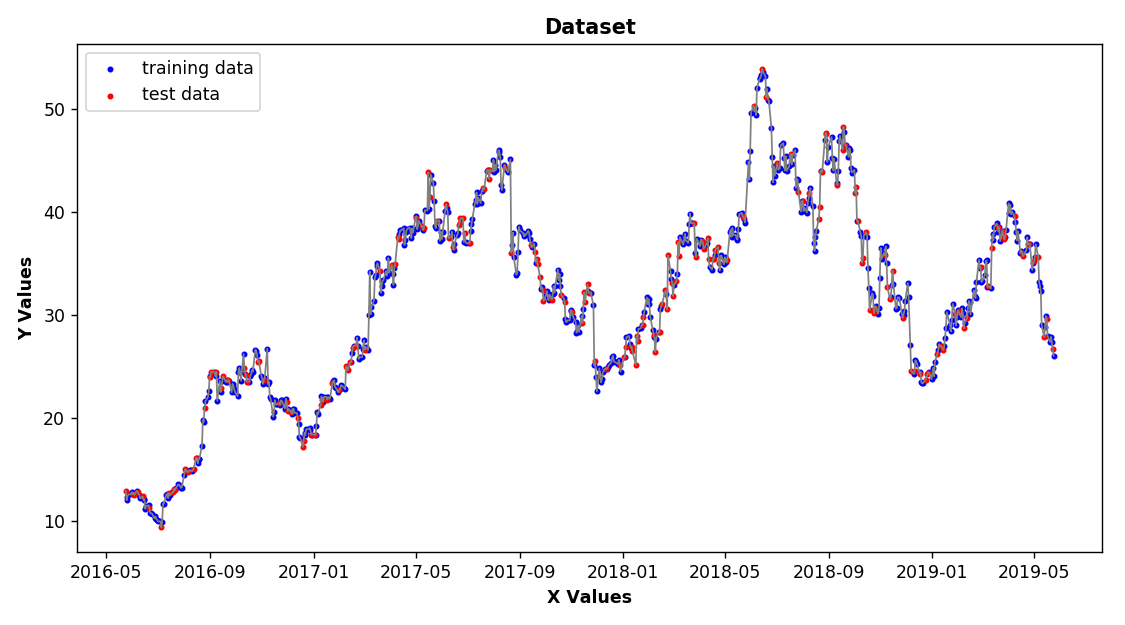

In [185]:
def plt_scatter():
    plt.figure(figsize=(9, 5))
    plt.plot(X, y, '-', c='grey', lw=1)
    plt.scatter(X_train, y_train, label='training data', c='blue', s=6)
    plt.scatter(X_test, y_test, label='test data', c='red', s=6)
    
    plt.legend(loc=2);
    plt.title('Dataset', weight='bold')
    plt.ylabel('Y Values', weight='bold')
    plt.xlabel('X Values', weight='bold')
    plt.tight_layout()


plt_scatter()

### Linear Regression with Polynomial Features

<IPython.core.display.Javascript object>


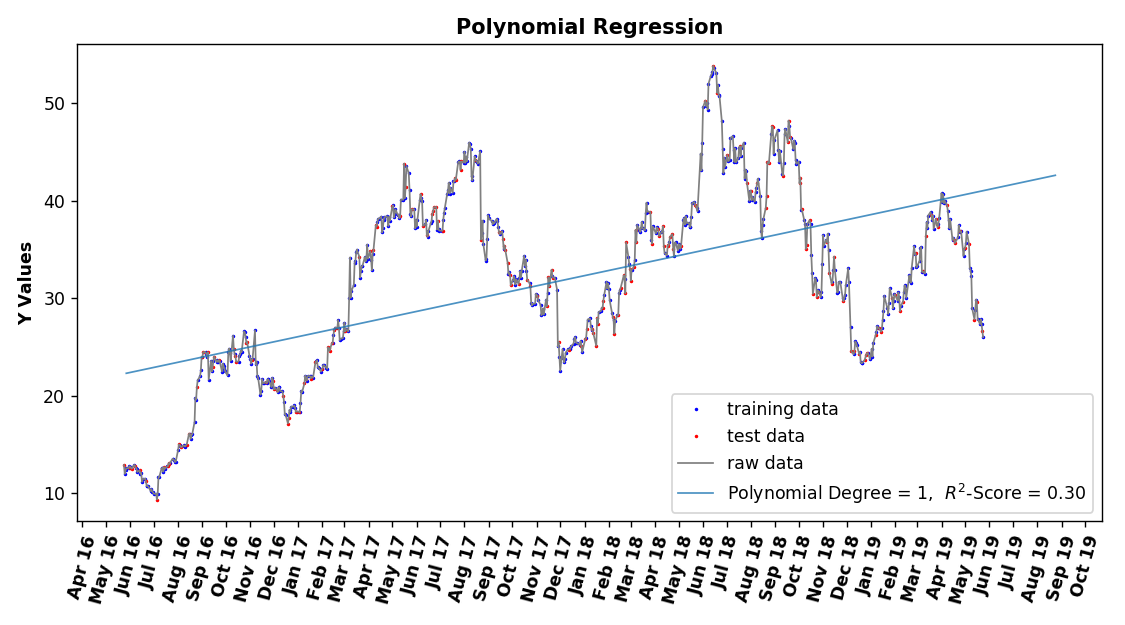

In [186]:
def polys():
    results = []
    for i, deg in enumerate(degrees):
        poly = PolynomialFeatures(degree=deg)
        X_poly_train = poly.fit_transform(X_train.reshape(-1, 1))
        X_poly_test = poly.transform(X_test.reshape(-1, 1))
        X_predict = poly.transform(predict.reshape(-1, 1))
        linreg = LinearRegression().fit(X_poly_train, y_train)
        results.append([predict, linreg.predict(X_predict), linreg.score(X_poly_test, y_test)])
    return results


def plot_polys(degree_predictions):
    plt.figure(figsize=(9, 5))
    plt.plot(X_train, y_train, '.', c='b', label='training data', markersize=2)
    plt.plot(X_test, y_test, '.', c='r', label='test data', markersize=2)
    plt.plot(X, y, '-', c='grey', lw=1, label='raw data')
    
    for i, degree in enumerate(degrees):
        #print(len(degree_predictions[i][0]), len(degree_predictions[i][1]))
        plt.plot(degree_predictions[i][0], 
                 degree_predictions[i][1], 
                 alpha=0.8, lw=1,
                 label='Polynomial Degree = {},  $R^2$-Score = {:.2f}'
                 .format(degree, degree_predictions[i][2])
                )
        
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(75)
        label.set_fontsize(10)
        label.set_weight('bold')
        
    plt.title('Polynomial Regression', weight='bold')
    plt.ylabel('Y Values', weight='bold')
    #plt.xlabel('X Values', weight='bold')
    plt.legend(loc=0)
    plt.tight_layout()

    
plot_polys(polys())